## To-Dos

- Add override capaility
- Add Covid19 scenarios
- Adjust population to be adult population

In [1]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
import seaborn as sns

import humanize

sns.set_style('white')
%matplotlib inline

In [2]:
axis_color = "0.4"
non_accent_light = "#dbdbdb"
non_accent_medium = "#bdbdbd"
non_accent_dark = "#a8a8a8"
accent = "#4599ff"
palette = sns.color_palette([non_accent_medium,accent])

In [3]:
def format_chart_axes(title,axes,x_label_format='{:,.1f}',x_label_scale=1,y_label_format='{:,.1f}',y_label_scale=1,color="black"):
    plt.title(title,y=1.05, color=color)

    axes.set_xticks(axes.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_xticklabels([x_label_format.format(x) for x in (axes.get_xticks()/x_label_scale).tolist()])
    
    axes.set_yticks(axes.get_yticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
    axes.set_yticklabels([y_label_format.format(x) for x in (axes.get_yticks()/y_label_scale).tolist()])

    axes.spines['bottom'].set_color(color)
    axes.xaxis.label.set_color(color)
    axes.tick_params(axis='x', colors=color)

    axes.spines['left'].set_color(color)
    axes.yaxis.label.set_color(color)
    axes.tick_params(axis='y', colors=color)

    sns.despine()    

## Data processing

In [40]:
econ_df = pd.DataFrame()
gambling_df = pd.DataFrame()
tnl_df  = pd.DataFrame()
hist_df = pd.DataFrame()

In [41]:
# Collect and organise GDP historical data - Source ONS

temp = pd.read_csv('./data/ABMI-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','GDP']

temp['GDP'] = pd.to_numeric(temp['GDP'])
temp['year'] = pd.to_numeric(temp['year'])

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [42]:
# Collect and organise Disposable Income historical data - Source ONS

temp = pd.read_csv('./data/QWND-290920.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','disposable income']

temp['disposable income'] = pd.to_numeric(temp['disposable income'])
temp['year'] = pd.to_numeric(temp['year'])
#temp['disposable income growth'] = temp['disposable income'].pct_change()

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [43]:
# Collect and organise Population historical data - Source ONS (Series: UKPOP)
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/timeseries/ukpop/pop

temp = pd.read_csv('./data/UKPOP-051020.csv')

temp = temp[temp['Title'].str.isnumeric()]

temp.columns = ['year','population']

temp['population'] = pd.to_numeric(temp['population'])/1000000
temp['year'] = pd.to_numeric(temp['year'])

temp.index = temp['year']
temp = temp.drop('year',axis=1)

econ_df = pd.concat([econ_df,temp],join='outer',axis=1)

In [44]:
# Collect and organise historical market and TNL data

temp = pd.read_csv('./data/marketdata.csv')
temp.index = temp['Year']
temp = temp.drop('Year',axis=1)


gambling_df = pd.concat(
    [gambling_df,
     temp[[
        'Gambling GGY',
        'Total gambling participation',
        'Agree that gambling is conducted fairly and can be trusted - All respondents',]].loc[:2019]
    ]
)

gambling_df.columns = [
    'gambling GGY',
    'gambling players',
    'trust gambling']

        
tnl_df = pd.concat(
    [tnl_df,
     temp[['TNL GGY',
           'TNL participation']].loc[:2019]
    ]
)

tnl_df.columns = [
    'TNL GGY', 
    'TNL players']

In [45]:
hist_df = pd.merge(
        econ_df,
        gambling_df,
        left_index=True,
        right_index=True,
        how='outer',
)

hist_df = pd.merge(
        hist_df,
        tnl_df,
        left_index=True,
        right_index=True,
        how='outer',
)

hist_df.index = hist_df.index.set_names('year')

## Model 1: TNL GGY projected based on Gambling market and TNL market share
#### Monte carlo simulation

In [119]:
iterations = 750
years_to_project = 10
initial_year = 2020

In [120]:
GDP_yoy_change_mean = 0.024383720592148272                    #Historical average of YoY growth in the period from 1956 to 2019
GDP_yoy_change_stdev = 0.020191051459338794                   #Historical stdev of YoY growth in the period from 1956 to 2019

population_yoy_change_mean = 0.003710395926661239
population_yoy_change_stdev = 0.00277374704172441

gambling_share_disposable_income_yoy_change_mean = -0.007      # Management judgement
gambling_share_disposable_income_yoy_change_stdev = 0.05312    #Historical stdev of YoY growth in the period from 2008 to 2019

trust_yoy_change_mean = -0.05164731382916463                   # Historical average of YoY growth in the period 2010 to 2019
trust_yoy_change_stdev = 0.0531155458747519                    # Historical stdev of YoY growth in the period 2010 to 2019

TNL_share_yoy_change_mean = 0.008682024533135794
TNL_share_yoy_change_stdev = 0.10145771199583832


In [121]:
projections_m1_df = pd.DataFrame()

for n in range(iterations):
    # Empty temporary dataframe to populate with this iteration and then append to projections dataframe
    tmp_df = pd.DataFrame()

    # Generate normally distributed values of input variables for this iteration
    projected_GDP_growth = np.random.normal(GDP_yoy_change_mean, GDP_yoy_change_stdev, years_to_project)
    projected_population_growth = np.random.normal(population_yoy_change_mean, population_yoy_change_stdev, years_to_project)
    projected_gambling_share_disposable_income_growth = np.random.normal(gambling_share_disposable_income_yoy_change_mean, gambling_share_disposable_income_yoy_change_stdev, years_to_project)    
    projected_trust_growth = np.random.normal(trust_yoy_change_mean, trust_yoy_change_stdev, years_to_project)
    projected_TNL_share_growth = np.random.normal(TNL_share_yoy_change_mean, TNL_share_yoy_change_stdev, years_to_project)    
    
    # Initialise years to project for this iteration
    tmp_df['year'] = np.arange(initial_year,initial_year+years_to_project)

    # Before applying growth projected variables = last historical value
    tmp_df['GDP'] = hist_df.loc[initial_year-1]['GDP']
    tmp_df['population'] = hist_df.loc[initial_year-1]['population']
    avg_spend_per_player_ini = hist_df.loc[initial_year-1]['gambling GGY'] / hist_df.loc[initial_year-1]['gambling players']
    disposable_income_per_capita_ini = hist_df.loc[initial_year-1]['disposable income'] / hist_df.loc[initial_year-1]['population']
    tmp_df['gambling share disposable income'] = avg_spend_per_player_ini / disposable_income_per_capita_ini
    tmp_df['trust gambling'] = hist_df.loc[initial_year-1]['trust gambling']
    tmp_df['TNL share'] = hist_df.loc[initial_year-1]['TNL GGY'] / hist_df.loc[initial_year-1]['gambling GGY']   
    
    #Calculate yearly growth factors (YOY_change + 1)
    GDP_growth_factor = pd.Series(projected_GDP_growth + 1)
    population_growth_factor = pd.Series(projected_population_growth + 1)
    gambling_share_disposable_income_growth_factor = pd.Series(projected_gambling_share_disposable_income_growth + 1)
    trust_growth_factor = pd.Series(projected_trust_growth + 1)
    TNL_share_growth_factor = pd.Series(projected_TNL_share_growth + 1)    
    
    # Apply growth to every year (e.g. get year 4 by applying to initial value the growth factors for years 1, 2 and 3)
    for i in range(years_to_project):
        tmp_df['GDP'] *= GDP_growth_factor.shift(i,fill_value=1)
        tmp_df['population'] *= population_growth_factor.shift(i,fill_value=1)
        tmp_df['gambling share disposable income'] *= gambling_share_disposable_income_growth_factor.shift(i,fill_value=1)
        tmp_df['trust gambling'] *= trust_growth_factor.shift(i,fill_value=1)
        tmp_df['TNL share'] *= TNL_share_growth_factor.shift(i,fill_value=1)        
        
    # Calculate variables in the rest of the model using inputs calculated for this iteration
    tmp_df['disposable income'] = (-1076261.5191325496 + (tmp_df['GDP'] * 1.2199441172482208))
    tmp_df['disposable income per capita'] = tmp_df['disposable income']/ tmp_df['population']
    tmp_df['gambling GGY per player'] = tmp_df['disposable income per capita'] * tmp_df['gambling share disposable income']
    tmp_df['gambling players'] = (0.30607425709282937 + ( tmp_df['trust gambling'] * 0.5589693711039558)) * tmp_df['population']
    tmp_df['gambling GGY'] = tmp_df['gambling players'] * tmp_df['gambling GGY per player']
    tmp_df['TNL GGY'] = tmp_df['gambling GGY'] * tmp_df['TNL share']    

    
    # Append results for this iteration in the projections dataframe
    projections_m1_df = pd.concat([tmp_df,projections_m1_df])
    
# Set the years as the index of the projections dataframe
projections_m1_df.index = projections_m1_df['year']

In [122]:
projections_m1_df.head(3)



,year,GDP,population,gambling share disposable income,trust gambling,TNL share,disposable income,disposable income per capita,gambling GGY per player,gambling players,gambling GGY,TNL GGY
year,,,,,,,,,,,,
2020,2020,2.186538e+06,67.429791,0.021799,0.265069,0.189249,1.591193e+06,23597.773512,514.405929,30.629287,15755.886593,2981.780891
2021,2021,2.260342e+06,67.733677,0.020225,0.264492,0.214451,1.681230e+06,24821.177310,501.998901,30.745496,15434.205351,3309.883849
2022,2022,2.320841e+06,68.254335,0.021214,0.223411,0.231735,1.755035e+06,25713.162562,545.468388,29.414487,16044.673041,3718.108859


In [123]:
hist_df.loc[2018:2019]

,GDP,disposable income,population,gambling GGY,gambling players,trust gambling,TNL GGY,TNL players
year,,,,,,,,
2018,2060494,1452493,66.4356,14329.38870,32.088924,0.30,3078.279571,23.683126
2019,2090632,1489473,66.7968,14449.05424,32.520366,0.29,3425.289279,32.439218


## Model 2: TNL GGY projected based on GDP and TNL % of Disp. Income%
#### Monte carlo simulation

In [124]:
iterations = 750
years_to_project = 10
initial_year = 2020

In [125]:
GDP_yoy_change_mean = 0.024383720592148272        #Historical average of YoY growth in the period from 1956 to 2019
GDP_yoy_change_stdev = 0.020191051459338794     #Historical stdev of YoY growth in the period from 1956 to 2019

TNL_shareDI_yoy_change_mean = 0.0003997407239658791
TNL_shareDI_yoy_change_stdev = 0.06419624024568973

In [126]:
projections_df = pd.DataFrame()

for n in range(iterations):
    # Empty temporary dataframe to populate with this iteration and then append to projections dataframe
    tmp_df = pd.DataFrame()

    # Generate normally distributed values of input variables for this iteration
    projected_GDP_growth = np.random.normal(GDP_yoy_change_mean, GDP_yoy_change_stdev, years_to_project)
    projected_tnl_share_growth = np.random.normal(TNL_shareDI_yoy_change_mean, TNL_shareDI_yoy_change_stdev, years_to_project)

    # Initialise years to project for this iteration
    tmp_df['year'] = np.arange(initial_year,initial_year+years_to_project)

    # Before applying growth projected variables = last historical value
    tmp_df['GDP'] = hist_df.loc[initial_year-1]['GDP']
    tmp_df['TNL share'] = hist_df.loc[initial_year-1]['TNL GGY'] / hist_df.loc[initial_year-1]['disposable income']
    
    #Calculate yearly growth factors (YOY_change + 1)
    GDP_growth_factor = pd.Series(projected_GDP_growth + 1)
    tnl_share_growth_factor = pd.Series(projected_tnl_share_growth + 1)

    # Apply growth to every year (e.g. get year 4 by applying to initial value the growth factors for years 1, 2 and 3)
    for i in range(years_to_project):
        tmp_df['GDP'] = tmp_df['GDP'] * GDP_growth_factor.shift(i,fill_value=1)
        tmp_df['TNL share'] = tmp_df['TNL share'] * tnl_share_growth_factor.shift(i,fill_value=1)

    # Calculate variables in the rest of the model using inputs calculated for this iteration
    tmp_df['disposable income'] = (-1076261.5191325496 + (tmp_df['GDP'] * 1.2199441172482208))
    tmp_df['TNL GGY'] = tmp_df['disposable income'] * tmp_df['TNL share']
    
    # Append results for this iteration in the projections dataframe
    projections_df = pd.concat([tmp_df,projections_df])
    
# Set the years as the index of the projections dataframe
projections_df.index = projections_df['year']

## Sandbox

### Regression of historical GDP vs Disposable Income

In [16]:
regr = linear_model.LinearRegression()

In [98]:
regr.fit(econ_df.loc[2008:2019]['GDP'].to_numpy().reshape(-1,1),econ_df.loc[2008:2019]['disposable income'])

LinearRegression()

In [99]:
disp_income_predict = regr.predict(econ_df['GDP'].to_numpy().reshape(-1,1))

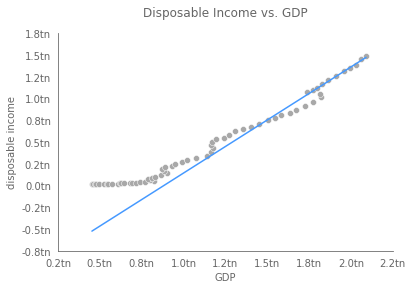

In [100]:
#plt.scatter(econ_df['GDP'].to_numpy().reshape(-1,1),econ_df['disposable income'],color='black')
#plt.plot(econ_df['GDP'].to_numpy().reshape(-1,1), disp_income_predict, color='blue', linewidth=3)

sns.scatterplot(x=econ_df['GDP'],
                y=econ_df['disposable income'],
                color=non_accent_dark)
ax = sns.lineplot(x=econ_df['GDP'],
             y=disp_income_predict,
            color=accent)

format_chart_axes("Disposable Income vs. GDP",
                  ax,
                  x_label_scale=1000000,
                  x_label_format='{:,.1f}tn',
                  y_label_scale=1000000,
                  y_label_format='{:,.1f}tn',
                  color=axis_color)

In [101]:
r2 = round(r2_score(econ_df['disposable income'],disp_income_predict),2)
intercept = humanize.intcomma(regr.intercept_,1)
coefficient = humanize.intcomma(regr.coef_[0],2)

In [105]:
regr.intercept_

-1076261.5191325496

In [106]:
regr.coef_[0]

1.2199441172482208

In [104]:
r2

0.76

### Regression of historical trust in gambling vs participation

In [74]:
regr = linear_model.LinearRegression()
regr.fit(hist_df.loc[2009:]['trust gambling'].to_numpy().reshape(-1,1),(hist_df.loc[2009:]['gambling players']/hist_df.loc[2009:]['population']))

LinearRegression()

In [77]:
participation_predict = regr.predict(hist_df.loc[2009:]['trust gambling'].to_numpy().reshape(-1,1))

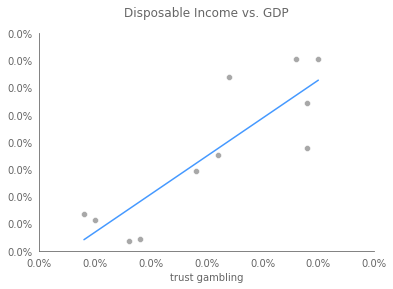

In [80]:
sns.scatterplot(x=hist_df.loc[2009:]['trust gambling'],
                y=(hist_df.loc[2009:]['gambling players']/hist_df.loc[2009:]['population']),
                color=non_accent_dark)
ax = sns.lineplot(x=hist_df.loc[2009:]['trust gambling'],
             y=participation_predict,
            color=accent)

format_chart_axes("Disposable Income vs. GDP",
                  ax,
                  x_label_scale=1000000,
                  x_label_format='{:,.1%}',
                  y_label_scale=1000000,
                  y_label_format='{:,.1%}',
                  color=axis_color)

In [85]:
intercept = humanize.intcomma(regr.intercept_,1)
regr.intercept_

0.30607425709282937

In [86]:
coefficient = humanize.intcomma(regr.coef_[0],2)
regr.coef_[0]

0.5589693711039558

In [87]:
regr.score(hist_df.loc[2009:]['trust gambling'].to_numpy().reshape(-1,1),(hist_df.loc[2009:]['gambling players']/hist_df.loc[2009:]['population']))

0.7377933826196552

### Historical behaviour: GDP YoY change

In [24]:
used = np.random.normal(GDP_yoy_change_mean, GDP_yoy_change_stdev, 500)

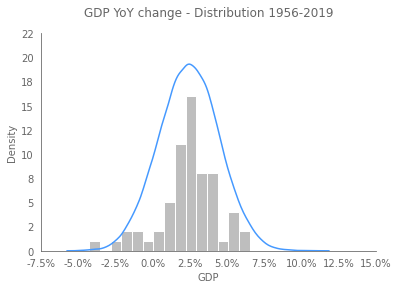

In [26]:
ax = sns.kdeplot(np.random.normal(GDP_yoy_change_mean, GDP_yoy_change_stdev, 25000),
                  color=accent)
ax = sns.histplot(hist_df['GDP'].pct_change(),
                  bins=15,
                  color=non_accent_dark)
format_chart_axes("GDP YoY change - Distribution 1956-2019",
                  ax,
                  x_label_format='{:,.1%}',
                  y_label_format='{:,.0f}',
                  color=axis_color)

In [27]:
gdp_yoy_change_mean = '{:.2%}'.format(hist_df['GDP'].pct_change().mean())

In [28]:
gdp_yoy_change_stdev = '{:.2%}'.format(hist_df['GDP'].pct_change().std())

##### GDP YoY change historical behaviour (1956-2019)

Average YoY GDP change {{gdp_yoy_change_mean}}

Yoy GDP change Standard Deviation {{gdp_yoy_change_stdev}}

### Historical behaviour: TNL share of disposable income YoY change

In [69]:
tnl_shareDI = hist_df['TNL GGY']/hist_df['disposable income']
tnl_shareDI_yoy_change_mean = tnl_shareDI.pct_change().mean()
tnl_shareDI_yoy_change_stdev = tnl_shareDI.pct_change().std()


In [68]:
tnl_shareDI_yoy_change_stdev

0.06419624024568973

### Historical behaviour: Population YoY change

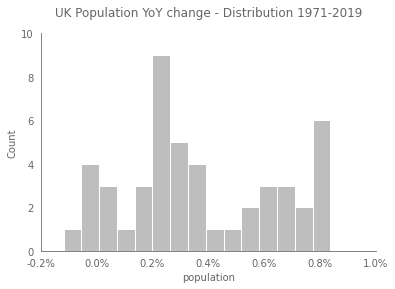

In [31]:
ax = sns.histplot(hist_df['population'].pct_change(),
                  bins=15,
                  color=non_accent_dark)
format_chart_axes("UK Population YoY change - Distribution 1971-2019",
                  ax,
                  x_label_format='{:,.1%}',
                  y_label_format='{:,.0f}',
                  color=axis_color)

In [32]:
hist_df['population'].pct_change().mean()

0.003710395926661239

In [33]:
hist_df['population'].pct_change().std()

0.00277374704172441

### Historical behaviour trust in gamblinf YoY change

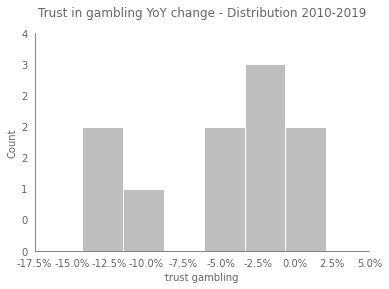

In [58]:
ax = sns.histplot(hist_df['trust gambling'].pct_change(),
                  bins=6,
                  color=non_accent_dark)
format_chart_axes("Trust in gambling YoY change - Distribution 2010-2019",
                  ax,
                  x_label_format='{:,.1%}',
                  y_label_format='{:,.0f}',
                  color=axis_color)

In [60]:
hist_df['trust gambling'].pct_change().mean()

-0.05164731382916463

In [59]:
hist_df['trust gambling'].pct_change().std()

0.0531155458747519

### Historical Behaviour: TNL market share YoY change

In [112]:
tnl_share = hist_df['TNL GGY'] / hist_df['gambling GGY']

In [113]:
tnl_share.pct_change().mean()

0.008682024533135794

In [114]:
tnl_share.pct_change().std()

0.10145771199583832

### Test

<AxesSubplot:xlabel='TNL GGY'>

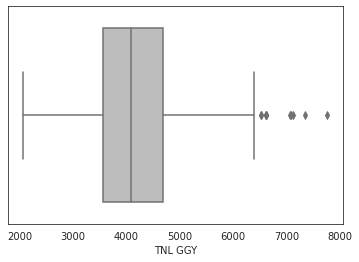

In [79]:
sns.boxplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium)

[Text(0.5, 0, '')]

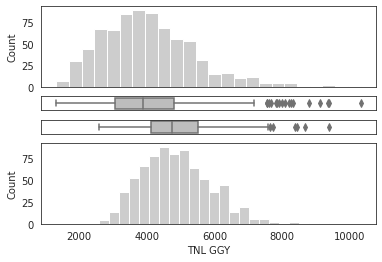

In [127]:
#Cut the window in 2 parts
f, (ax_hist1, ax_box1, ax_box2, ax_hist2) = plt.subplots(4, sharex=True, gridspec_kw={"height_ratios": (.85, .15, .15, .85)})
 
# Add a graph in each part
sns.boxplot(x=projections_m1_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_box1)
sns.histplot(x=projections_m1_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_hist1)
sns.boxplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_box2)
sns.histplot(x=projections_df.loc[2028]['TNL GGY'],color=non_accent_medium, ax=ax_hist2)


# Remove x axis name for the boxplot
ax_box1.set(xlabel='')
ax_box2.set(xlabel='')

In [ ]:
projections_df.loc[2028]['TNL GGY'].describe()

count     750.000000
mean     4138.199088
std       829.323633
min      2209.756714
25%      3525.595487
50%      4087.380672
75%      4669.786221
max      7069.350202
Name: TNL GGY, dtype: float64